# Author: Lukas Delaye
## Goal: Visualize the electric field impact of a probe at the Lyot plane to check for vignetting.
# README :
- Here is a test with only single probe, but you can change it!
- Read the whole block because you need to make a copy of roman_preflight.py at some point, so don’t skip it /!\
- Be careful with the path, because it’s my notebook, I try to make it general but I can make mistakes :)


# FIRST : COMPACT MODEL

In [1]:
# Imports and Path Configuration
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

# Compact model
import corgihowfsc
from corgihowfsc.utils.howfsc_initialization import get_args, load_files
from howfsc.model.mode import CoronagraphMode

howfsc_root = os.path.dirname(os.path.abspath(corgihowfsc.__file__))
model_dir = os.path.join(howfsc_root, 'model')

# Flat DM for the reference e_field
dm1_flat_path = os.path.join(model_dir, 'dm1', 'dm_allzeros.fits')
dm2_flat_path = os.path.join(model_dir, 'dm2', 'dm_allzeros.fits')

# Arguments
args = get_args(
    niter=1,
    mode='nfov_band1',  # Adjust if working in another band
    precomp='precomp_jacs_always',
    jacpath=os.path.join(os.path.dirname(howfsc_root), 'temp'), # Temp path
    fileout=os.path.join(os.getcwd(), 'output_debug')
)
_, cfgfile, _, _, _, _, _, _ = load_files(args, howfsc_root)
cfg = CoronagraphMode(cfgfile)


In [2]:
# load DM
dm1_flat = fits.getdata(dm1_flat_path)
dm2_flat = fits.getdata(dm2_flat_path)

# Load probes (here the single actuator probe for e.g.)
probe_filename = 'narrowfov_dmrel_1.0e-05_three.fits'
probe_path = os.path.join(model_dir, 'probes', probe_filename)
probe_cmd = fits.getdata(probe_path)

# Apply probe to DM1 (not DM2 /!\)
dm1_with_probe = dm1_flat + probe_cmd
dmlist_probe = [dm1_with_probe, dm2_flat]


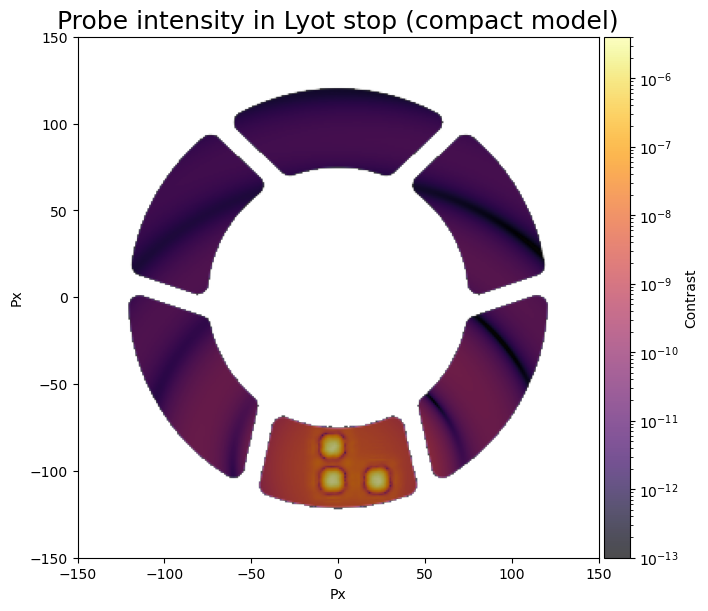

In [3]:
# Wavelenght 0 for e.g.
sl = cfg.sl_list[0]

lyot_mask_fits = np.abs(sl.lyot.e) # Amplitude transmission

# Propagation
dmlist_ref = [dm1_flat, dm2_flat] # Flat DMs from Cell 2
edm0_ref = sl.eprop(dmlist_ref)
E_lyot_ref = sl.proptolyot(edm0_ref)
I_ref = np.abs(E_lyot_ref)**2  # Intensity of starlight

# Probe e_field
edm0_probe = sl.eprop(dmlist_probe)
E_lyot_total = sl.proptolyot(edm0_probe)

# Delta_E to isolate probe impact
Delta_E = E_lyot_total - E_lyot_ref
I_probe = np.abs(Delta_E)**2
I_probe = np.fliplr(I_probe)
I_probe = np.rot90(I_probe, k=3)

ny, nx = I_probe.shape
extent_val = [-nx//2, nx//2, -ny//2, ny//2]

# Plotting function
def add_colorbar(ax, im, label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    return cbar

# Plotting
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

# E_field probe > I
vmin_probe = max(1e-13, I_probe.max() * 1e-8)
vmax_probe = I_probe.max()

ax.set_title(r"Probe intensity in Lyot stop (compact model)",  fontsize = 18)
ax.set_xlabel("Px")
ax.set_ylabel("Px")

# Display
lyot_mask_fits = np.fliplr(lyot_mask_fits)
lyot_mask_fits = np.rot90(lyot_mask_fits, k=3)

ax.imshow(lyot_mask_fits, origin='lower', cmap='gray_r', alpha=1.0, extent=extent_val)

if vmax_probe > 0:
    probe_masked = np.ma.masked_where(I_probe < vmin_probe, I_probe)
    im3 = ax.imshow(probe_masked, origin='lower', cmap='inferno',
                         norm=LogNorm(vmin=vmin_probe, vmax=vmax_probe), alpha=0.7, extent=extent_val)
    add_colorbar(ax, im3, "Contrast")

zoom_pixel = 150
ax.set_xlim(-zoom_pixel, zoom_pixel)
ax.set_ylim(-zoom_pixel, zoom_pixel)

# Save and Show
plt.savefig("test_lyot_compact_model.png", dpi=300)

# SECOND : FULL MODEL

In [ ]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import yaml
import proper # Required for manual propagation
import corgihowfsc
from corgihowfsc.utils.corgisim_manager import CorgisimManager
from howfsc.model.mode import CoronagraphMode
from howfsc.control.cs import ControlStrategy
from howfsc.util.loadyaml import loadyaml
from matplotlib.lines import Line2D
import roman_preflight_proper
if not os.path.exists('roman_preflight.py'):
    roman_preflight_proper.copy_here()

In [ ]:
# Configs of paths

repo_root = os.path.dirname(os.path.abspath(corgihowfsc.__file__))
model_root = os.path.join(repo_root, "model")
nfov_dir = os.path.join(model_root, "nfov_band1", "nfov_band1_360deg")
probes_dir = os.path.join(model_root, "probes")

# Config files
yaml_file = os.path.join(nfov_dir, "howfsc_optical_model.yaml")
hconf_file = os.path.join(model_root, "nfov_band1", "hconf_nfov_flat.yaml")
cstrat_file = os.path.join(nfov_dir, "cstrat_nfov_band1.yaml")

# Probe file to analyze
probe_filename = 'narrowfov_dmrel_1.0e-05_three.fits'
probe_file = os.path.join(probes_dir, probe_filename)
print(model_root)

## Load the entire optical prescription for the Roman telescope (pupil, mirrors, DMs, FPM) with the FULL MODEL
#### Notice : Using is_noise_free: True is perfect. For this diagnosis, we want to see the pure physics of diffraction, without photon or readout noise that would cloud the analysis.

In [ ]:
# Inits
cfg = CoronagraphMode(yaml_file)
cstrat = ControlStrategy(cstrat_file)
hconf = loadyaml(hconf_file, custom_exception=TypeError)

# Initialize CorgisimManager (The Full Optical Model wrapper)
overrides = {
    'bandpass': '1',
    'is_noise_free': True,
    'output_dim': 153
}
manager = CorgisimManager(cfg, cstrat, hconf, cor='nfov_flat', corgi_overrides=overrides)

In [ ]:
probe_map = fits.getdata(probe_file)

# My DM commands
# dm1_probe = Flat map + Probe perturbation
dm1_flat = np.zeros(probe_map.shape)
dm1_probe = dm1_flat + probe_map
dm2_flat = np.zeros(probe_map.shape)

## Instead of letting the simulator go all the way to the detector (which is what get_image does by default), we want to force the propagation engine (PROPER) to stop immediately after the Lyot Stop plane via the end_at_lyot_stop flag.
#### Notice : I calculate the total field with the probe, and subtract the reference field (without probe) to see only the effect off the probes.

In [ ]:
#  My propagation to Lyot functions
def get_lyot_plane_field(mgr, dm1_v, dm2_v, end_plane_to_simulate='end_at_fpm_exit_pupil'):

    # Create corgi object
    optics = mgr.create_optics(dm1_v, dm2_v, lind=0)

    # Retrieve the good keyword to stop at Lyot stop
    passvalue = optics.optics_keywords.copy()
    passvalue[end_plane_to_simulate] = 1
    passvalue['use_lyot_stop'] = 1
    passvalue['use_fpm'] = 1

    # Run PROPER
    (fields, sampling) = proper.prop_run_multi(
        'roman_preflight',
        optics.lam_um,
        1024, # Grid size (Pupil usually ~1000 pix)
        PASSVALUE=passvalue,
        QUIET=True
    )

    return fields[0]



### You must write two lines in the 'roman_preflight.py' that you just copied in your working directory (from first block when you import it).
### You need to modify it by adding the following 2 lines after the line 1104 where proper.prop_multiply( wavefront, lyot ) is called :
----------------------------------
##### from astropy.io import fits
##### fits.writeto("Lyot_proper_sampling.fits", np.abs(lyot), overwrite=True)
----------------------------------

You can do it manually. Or, to do it automatically, run this bloc :

In [ ]:
def auto_patch_roman_preflight_robust():
    filename = 'roman_preflight.py'

    # Check if file exists
    if not os.path.exists(filename):
        print(f"Error: {filename} not found.")
        return

    with open(filename, 'r') as f:
        lines = f.readlines()

    # Check if already patched
    if "Writing in the file here" in "".join(lines):
        print(f"{filename} is already patched. All good.")
        return

    # Search for insertion point (After Lyot application)
    anchor_text = "proper.prop_multiply( wavefront, lyot )"
    insert_index = -1
    indentation = "    " # Default 4 spaces

    for i, line in enumerate(lines):
        if anchor_text in line:
            insert_index = i + 1
            # Copy indentation from the found line
            indentation = line[:line.find(anchor_text.strip())]
            break

    if insert_index == -1:
        print(f"Error: Anchor line '{anchor_text}' not found.")
        return

    # Code to insert in the proper.py file :
    code_to_insert = [
        "\n",
        f"{indentation}# --- Writing in the file here ---\n",
        f"{indentation}try:\n",
        f"{indentation}    import os\n",
        f"{indentation}    from astropy.io import fits\n",
        f"{indentation}    # Write only if the file does not exist yet\n",
        f"{indentation}    if not os.path.exists('Lyot_proper_sampling.fits'):\n",
        f"{indentation}        fits.writeto('Lyot_proper_sampling.fits', np.abs(lyot), overwrite=True)\n",
        f"{indentation}except Exception:\n",
        f"{indentation}    # If file is locked by another thread, ignore silently\n",
        f"{indentation}    pass\n",
        f"{indentation}# ----------------------------------------------\n",
        "\n"
    ]

    new_lines = lines[:insert_index] + code_to_insert + lines[insert_index:]

    with open(filename, 'w') as f:
        f.writelines(new_lines)

    print(f"Success: {filename} has been patched.")

# Apply patch
auto_patch_roman_preflight_robust()

In [ ]:
# This image is not relevant : just here to retrieve the Lyot stop (do it one time and it's fine).
Image = get_lyot_plane_field(manager, dm1_flat, dm2_flat, end_plane_to_simulate='end_at_exit_pupil')


In [ ]:
E_ref = get_lyot_plane_field(manager, dm1_flat, dm2_flat)
E_probe = get_lyot_plane_field(manager, dm1_probe, dm2_flat)

# Differential field (The E-field added by the probe)
Delta_E = E_probe - E_ref

In [ ]:
# Load Data
with open(yaml_file, 'r') as f:
    raw_cfg = yaml.safe_load(f)

lyot_mask_fits = fits.getdata("Lyot_proper_sampling.fits")

# Helper for colorbars
def add_colorbar(ax, im, label):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    return cbar

data_probe_full = np.abs(Delta_E)**2
lyot_mask_full = fits.getdata("Lyot_proper_sampling.fits")

ny_full, nx_full = data_probe_full.shape
cy, cx = ny_full // 2, nx_full // 2
nx_compact, ny_compact = 500, 500

x1 = cx - nx_compact // 2
x2 = x1 + nx_compact
y1 = cy - ny_compact // 2
y2 = y1 + ny_compact

data_probe_full = np.abs(Delta_E)**2
lyot_mask_full = fits.getdata("Lyot_proper_sampling.fits")
ny_full, nx_full = data_probe_full.shape
extent_full = [-nx_full//2, nx_full//2, -ny_full//2, ny_full//2]

vmax_probe = data_probe_full.max()
vmin_probe = max(1e-13, vmax_probe * 1e-8)

# Plotting
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

ax.set_title(r"Probe intensity in Lyot stop (full model)", fontsize=18)

ax.set_xlabel("Px")
ax.set_ylabel("Px")
ax.imshow(lyot_mask_full, origin='lower', cmap='gray_r', alpha=1.0, extent=extent_full)

if vmax_probe > 0:
    condition_mask = (data_probe_full < vmin_probe) | (lyot_mask_full < 0.5)
    probe_masked = np.ma.masked_where(condition_mask, data_probe_full)
    im3 = ax.imshow(probe_masked, origin='lower', cmap='inferno',
                    norm=LogNorm(vmin=vmin_probe, vmax=vmax_probe), alpha=0.7, extent=extent_full)

    add_colorbar(ax, im3, "Contrast")

zoom_pixel = 150
ax.set_xlim(-zoom_pixel, zoom_pixel)
ax.set_ylim(-zoom_pixel, zoom_pixel)

plt.savefig("test_lyot_full_model.png", dpi=300)